# Introduction to Data Science

### Project topic: Weather forecasting in Toronto City

### Description
- _This is a project to apply our knowlegde in Data Science to solve the weather forecasting problem in Toronto City._

- _The dataset that we have collected is from the Canada government's website: [climate](https://climate.weather.gc.ca/historical_data/search_historic_data_e.html)_

- _In this case, we are going to use Python frameworks like: `requests`, `BeautifulSoup` to automatically collect the data._

- _Based on the collected dataset, we will apply some DS techniques in order to forecast the weather in Toronto City hourly._

### Group - 07:
- **21127072 - Nguyễn Hữu Khánh**
- 21127160 - Nguyễn Thanh Sơn
- 21127246 - Lê Minh Đức

### Prepare

- Install libraries

In [ ]:
!pip install requests
!pip install beautifulsoup4
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install lxml

In [ ]:
%pip install statsmodels
%pip install adfuller
%pip install SMOTE
%pip install imbalanced-learn

In [5]:
%pip install statsmodels

     ---------------------------------------- 9.8/9.8 MB 11.9 MB/s eta 0:00:00
     ---------------------------------------- 232.9/232.9 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


- Import libraries

In [44]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import selenium as se
import math
import seaborn as sns
import concurrent.futures
import os
import copy
from datetime import datetime
from bs4 import BeautifulSoup
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import IsolationForest

- Declare important variables

In [ ]:
# Data URL
url = 'https://climate.weather.gc.ca/climate_data/hourly_data_e.html'

# DataFrame to store data
data = pd.DataFrame()

### Support Function

In [27]:
def is_valid_date(year, month, day):
    try:
        datetime(year, month, day)
        return True
    except ValueError:
        return False
    
def fixDataFramTimeUTC(df, year, month, day):
    nump = np.asarray(df['TIME UTC'])
    nump = datetime(year,month,day).strftime("%Y-%m-%d") + "T" + nump
    df['TIME UTC'] = nump

### Get data

In [ ]:
def getDataFromWeb(m_start, y_start, m_end, y_end, url_data):
    result = None
    for year in range(y_start, y_end + 1):
        for month in range(1, 13):
            for day in range(1, 32):
                if not is_valid_date(year, month, day) \
                    or ((year == y_start and month < m_start) or (year == y_end and month > m_end)):
                    continue 
                print(f'{year}-{month}-{day}')   
                params = {'StationID': '31688', 'selRowPerPage': 25, 'timeframe': 1, 'time': 'UTC', 'Year': year, 'Month': month, 'Day': day}
                response = requests.get(url_data, params=params)
                soup = BeautifulSoup(response.text,'html.parser')
                daily_table = soup.find('table')
                df = pd.read_html(StringIO(str(daily_table)))[0]
                fixDataFramTimeUTC(df, year, month, day)
                result = pd.concat([result, df], ignore_index=True)
    return result
    

In [ ]:
data = getDataFromWeb(1,2020,2,2020,url)

In [1]:
data.info()

NameError: name 'data' is not defined

### Data preprocessing

#### Remove unnecessary or unpredictable columns

In [34]:
datas = datas[["TIME UTC",
               "Temp Definition °C",
               "Dew Point Definition °C", 
               "Rel Hum Definition %", 
               "Precip. Amount Definition mm", 
               "Stn Press Definition kPa", 
               "Hmdx Definition", 
               "Weather Definition"]]

#### Handle missing value

##### Fill in missing data rows

In [4]:
file_path = "weather_data_clone.csv"
data_set = pd.read_csv(file_path, 
                       sep=',', 
                       low_memory=False)

#column picker
data_set_clone = data_set.copy()
label = "Stn Press Definition kPa"
column = data_set_clone[label]
column_length = len(column)
#cell checker
for i in range(column_length):
    cell = column[i]
    if cell is np.nan or \
        cell == "LegendMM":
        counter = 0
        accumulate = 0
        #15 days before and after a timestamp
        #accumulate the sum to average later
        for j in range (15):
            before_index = i - (j + 1) * 24
            after_index = i + (j + 1) * 24
            if before_index >= 0 and \
                column[before_index] is not np.nan and \
                column[before_index] != "LegendMM":
                counter += 1
                accumulate += float(column[before_index])
            if after_index < column_length and \
                column[after_index] is not np.nan and \
                      column[after_index] != "LegendMM":
                counter += 1
                accumulate += float(column[after_index])
        #update cell value direct by mean
        if counter != 0:
            data_set_clone.loc[i, label] = accumulate / counter
        else:
            data_set_clone.loc[i, label] = 0
        #data_set["Temp Definition °C"][i] = cell

data_set_clone.to_csv("weather_data_clone.csv", index=False)
        
#Affected: Temp Definition °C, Dew Point Definition °C, Rel Hum Definition %, Precip. Amount Definition mm

##### Fill in the humidex index columns

- Convert `datas` to _list_

In [37]:
data_list = datas.values.tolist()

- Setup humidex calculate function

$$H = T_{air} + \frac{5}{9} (6.11 exp(5417.7530(\frac{1}{273.15} - \frac{1}{273.15 + T_{dew}})) - 10)$$

  - **Where:**
    - **$H$:** denotes the Humidex
    - **$T_{air}$:** is the air temperature in °C
    - **$T_{dew}$:** is the dewpoint temperature in °C
    - **$exp$:** is the exponential function

  - _Reference: [Wikipedia](https://en.wikipedia.org/wiki/Humidex)_

In [38]:
def hmdx_cal(temp, dew):
    try:
        temp = float(temp)
        dew = float(dew)
    except(ValueError, TypeError):
        return -1
    
    result = temp + (5/9) * (6.11 * math.exp(5417.7530 * ((1 / 273.15)-(1 / (273.15 + dew))))-10)

    return max(result, 0) # Because if humidex < 0, then it is not necessary

- Use `hmdx_cal` to calculate humidex

In [39]:
for item in data_list:
    item[6] = round(hmdx_cal(item[1], item[2]),0)

[['2020-01-01T00:00', 0.7, -4.5, 68.0, 0.0, 98.7, 0, 'LegendNANA'],
 ['2020-01-01T01:00', 0.4, -4.6, 69.0, 0.0, 98.73, 0, 'LegendNANA'],
 ['2020-01-01T02:00', 0.2, -4.9, 68.0, 0.0, 98.75, 0, 'LegendNANA'],
 ['2020-01-01T03:00', -0.1, -5.0, 69.0, 0.0, 98.77, 0, 'LegendNANA'],
 ['2020-01-01T04:00', -0.2, -4.6, 72.0, 0.0, 98.81, 0, 'LegendNANA'],
 ['2020-01-01T05:00', -0.1, -5.2, 69.0, 0.0, 98.82, 0, 'LegendNANA'],
 ['2020-01-01T06:00', -0.1, -4.9, 70.0, 0.0, 98.84, 0, 'LegendNANA'],
 ['2020-01-01T07:00', -0.1, -5.5, 67.0, 0.0, 98.87, 0, 'LegendNANA'],
 ['2020-01-01T08:00', -0.4, -5.3, 69.0, 0.0, 98.91, 0, 'LegendNANA'],
 ['2020-01-01T09:00', -0.7, -4.5, 75.0, 0.0, 98.96, 0, 'LegendNANA'],
 ['2020-01-01T10:00', -0.5, -4.9, 72.0, 0.2, 98.96, 0, 'LegendNANA'],
 ['2020-01-01T11:00', -0.6, -4.8, 73.0, 0.0, 98.99, 0, 'LegendNANA'],
 ['2020-01-01T12:00', -0.5, -4.8, 72.0, 0.0, 99.05, 0, 'LegendNANA'],
 ['2020-01-01T13:00', -0.4, -5.6, 68.0, 0.0, 99.11, 0, 'LegendNANA'],
 ['2020-01-01T14:00', -0

In [7]:
original_df = pd.read_csv("weather_data.csv")

C:\Users\phamg\AppData\Local\Temp\ipykernel_16104\3910693798.py:1: DtypeWarning: Columns (1,2,3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv("weather_data.csv")


In [8]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82536 entries, 0 to 82535
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TIME UTC                      82536 non-null  object 
 1   Temp Definition °C            82287 non-null  object 
 2   Dew Point Definition °C       82288 non-null  object 
 3   Rel Hum Definition %          82288 non-null  object 
 4   Precip. Amount Definition mm  82288 non-null  object 
 5   Wind Dir Definition 10's deg  38548 non-null  object 
 6   Wind Spd Definition km/h      38548 non-null  object 
 7   Visibility Definition km      0 non-null      float64
 8   Stn Press Definition kPa      82288 non-null  object 
 9   Hmdx Definition               13528 non-null  float64
 10  Wind Chill Definition         0 non-null      float64
 11  Weather Definition            82288 non-null  object 
dtypes: float64(3), object(9)
memory usage: 7.6+ MB


In [9]:
original_df.drop(columns=["Wind Dir Definition 10's deg", "Wind Spd Definition km/h", "Visibility Definition km", \
                          "Wind Chill Definition", "Hmdx Definition", "Weather Definition"], inplace=True)

original_df.to_csv("weather_data_drop.csv", index=False)

#### Drop: <i>Wind Dir Definition 10's deg, Wind Spd Definition km/h, Visibility Definition km, Wind Chill Definition, Hmdx Definition, Weather Definition.</i>

Gắn thêm cột ngày, tháng, năm vào để dễ làm việc

In [16]:
#original_df.drop(columns=["Wind Dir Definition 10's deg", "Wind Spd Definition km/h", "Visibility Definition km", \
#                          "Wind Chill Definition", "Hmdx Definition", "Weather Definition"], inplace=True)
original_df['Time'] = pd.to_datetime(original_df['TIME UTC']).dt.time
original_df['Day'] = pd.to_datetime(original_df['TIME UTC']).dt.day # get the day of Time UTC
original_df['Month'] = pd.to_datetime(original_df['TIME UTC']).dt.month
original_df['Year'] = pd.to_datetime(original_df['TIME UTC']).dt.year

#### Handle missing value: 
- Không thể drop missing value do đây là dữ liệu có yếu tố thời gian.

- Chiến lược
    -> Điền vào các cột trống giá trị của hàng cùng giờ, cùng ngày, cùng tháng nhưng có giá trị năm trong quá khứ gần nhất.
        => Cùng tháng, cùng mùa trong năm thì trong phần lớn trường hợp sẽ tương đồng nhau về nhiệt độ, độ ẩm và các yếu tố khác


In [18]:
def fill_missing(column: str, df: pd.DataFrame):
    NaN_indices = df[pd.isna(df[column])].index
    
    for i in NaN_indices:
        year = df.at[i, 'Year']
        month = df.at[i, 'Month']
        day = df.at[i, 'Day']
        time = df.at[i, 'Time']
        filled = False
        
        # Tìm giá trị trong quá khứ
        for j in range(year - 1, 2015 - 1, -1):
            value = df[(df['Time'] == time) & (df['Day'] == day) & (df['Month'] == month) & (df['Year'] == j)]
            if not value.empty and not pd.isna(value[column].iloc[0]):
                df.at[i, column] = (value[column].iloc[0])
                filled = True
                break
        
        # Tìm giá trị trong tương lai
        if not filled:
            for j in range(year + 1, 2024 + 1):
                value = df[(df['Time'] == time) & (df['Day'] == day) & (df['Month'] == month) & (df['Year'] == j)]
                if not value.empty and not pd.isna(value[column].iloc[0]):
                    df.at[i, column] = (value[column].iloc[0])
                    filled = True
                    break

columns2Fill = ['Temp Definition °C', 'Dew Point Definition °C', 'Rel Hum Definition %', 'Precip. Amount Definition mm', 'Stn Press Definition kPa']

for column in columns2Fill:
    fill_missing(column, original_df)

In [19]:
original_df.drop(columns=['Year', 'Month', 'Day','Time']).info(verbose=True, memory_usage=False, )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82536 entries, 0 to 82535
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   TIME UTC                      82536 non-null  object
 1   Temp Definition °C            82536 non-null  object
 2   Dew Point Definition °C       82536 non-null  object
 3   Rel Hum Definition %          82536 non-null  object
 4   Precip. Amount Definition mm  82536 non-null  object
 5   Stn Press Definition kPa      82536 non-null  object
dtypes: object(6)

In [20]:
for column in columns2Fill:
    original_df[column] = pd.to_numeric(original_df[column], errors='coerce')

In [21]:
original_df.to_csv('handledMising.csv')

In [22]:
# Ensure the columns are numeric and handle errors by coercing them to NaN
numeric_columns = ['Temp Definition °C', 'Dew Point Definition °C', 'Rel Hum Definition %', \
                    'Precip. Amount Definition mm', 'Stn Press Definition kPa']

for column in numeric_columns:
    original_df[column] = pd.to_numeric(original_df[column], errors='coerce')

# Nhóm dữ liệu theo ngày, tháng, năm
grouped_df = original_df.groupby(['Year', 'Month', 'Day'])

# Tính giá trị trung bình, lớn nhất và nhỏ nhất cho các thuộc tính
aggregated_df = grouped_df.agg({
    'Temp Definition °C': ['mean', 'max', 'min'],
    'Dew Point Definition °C': ['mean', 'max', 'min'],
    'Rel Hum Definition %': ['mean', 'max', 'min'],
    'Precip. Amount Definition mm': ['sum'],
    'Stn Press Definition kPa': ['mean', 'max', 'min']
}).reset_index()

# Đổi tên các cột cho dễ đọc
aggregated_df.columns = ['Year', 'Month', 'Day',
                         'Temp_mean', 'Temp_max', 'Temp_min',
                         'DewPoint_mean', 'DewPoint_max', 'DewPoint_min',
                         'RelHum_mean', 'RelHum_max', 'RelHum_min',
                         'PrecipAmount_sum',
                         'StnPress_mean', 'StnPress_max', 'StnPress_min']

new_numberic_columns = ['Temp_mean', 'Temp_max', 'Temp_min',
                         'DewPoint_mean', 'DewPoint_max', 'DewPoint_min',
                         'RelHum_mean', 'RelHum_max', 'RelHum_min',
                         'PrecipAmount_sum',
                         'StnPress_mean', 'StnPress_max', 'StnPress_min']

for column in new_numberic_columns:
    aggregated_df[column] = aggregated_df[column].round(3)
    

# Lưu DataFrame đã được tính toán vào file CSV
aggregated_df.to_csv('preProcessedData.csv', index=False)

aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int32  
 1   Month             3439 non-null   int32  
 2   Day               3439 non-null   int32  
 3   Temp_mean         3439 non-null   float64
 4   Temp_max          3439 non-null   float64
 5   Temp_min          3439 non-null   float64
 6   DewPoint_mean     3439 non-null   float64
 7   DewPoint_max      3439 non-null   float64
 8   DewPoint_min      3439 non-null   float64
 9   RelHum_mean       3439 non-null   float64
 10  RelHum_max        3439 non-null   float64
 11  RelHum_min        3439 non-null   float64
 12  PrecipAmount_sum  3439 non-null   float64
 13  StnPress_mean     3439 non-null   float64
 14  StnPress_max      3439 non-null   float64
 15  StnPress_min      3439 non-null   float64
dtypes: float64(13), int32(3)
memory usage: 389

In [23]:
import pandas as pd

# Đọc dữ liệu đã được tiền xử lý
df = pd.read_csv('preProcessedData.csv')

In [24]:
df.drop(columns=['Year', 'Month', 'Day']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp_mean         3439 non-null   float64
 1   Temp_max          3439 non-null   float64
 2   Temp_min          3439 non-null   float64
 3   DewPoint_mean     3439 non-null   float64
 4   DewPoint_max      3439 non-null   float64
 5   DewPoint_min      3439 non-null   float64
 6   RelHum_mean       3439 non-null   float64
 7   RelHum_max        3439 non-null   float64
 8   RelHum_min        3439 non-null   float64
 9   PrecipAmount_sum  3439 non-null   float64
 10  StnPress_mean     3439 non-null   float64
 11  StnPress_max      3439 non-null   float64
 12  StnPress_min      3439 non-null   float64
dtypes: float64(13)
memory usage: 349.4 KB


In [25]:
original_df = pd.read_csv('weather_data.csv', low_memory=False)

In [26]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82536 entries, 0 to 82535
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TIME UTC                      82536 non-null  object 
 1   Temp Definition °C            82287 non-null  object 
 2   Dew Point Definition °C       82288 non-null  object 
 3   Rel Hum Definition %          82288 non-null  object 
 4   Precip. Amount Definition mm  82288 non-null  object 
 5   Wind Dir Definition 10's deg  38548 non-null  object 
 6   Wind Spd Definition km/h      38548 non-null  object 
 7   Visibility Definition km      0 non-null      float64
 8   Stn Press Definition kPa      82288 non-null  object 
 9   Hmdx Definition               13528 non-null  float64
 10  Wind Chill Definition         0 non-null      float64
 11  Weather Definition            82288 non-null  object 
dtypes: float64(3), object(9)
memory usage: 7.6+ MB


In [27]:
processed_df = pd.read_csv("preProcessedData.csv", low_memory=False)

processed_df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   Temp_max          3439 non-null   float64
 5   Temp_min          3439 non-null   float64
 6   DewPoint_mean     3439 non-null   float64
 7   DewPoint_max      3439 non-null   float64
 8   DewPoint_min      3439 non-null   float64
 9   RelHum_mean       3439 non-null   float64
 10  RelHum_max        3439 non-null   float64
 11  RelHum_min        3439 non-null   float64
 12  PrecipAmount_sum  3439 non-null   float64
 13  StnPress_mean     3439 non-null   float64
 14  StnPress_max      3439 non-null   float64
 15  StnPress_min      3439 non-null   float64
dtypes: float64(13), int64(3)

In [28]:
processed_df.head()

,Year,Month,Day,Temp_mean,Temp_max,Temp_min,DewPoint_mean,DewPoint_max,DewPoint_min,RelHum_mean,RelHum_max,RelHum_min,PrecipAmount_sum,StnPress_mean,StnPress_max,StnPress_min
0,2015,1,1,-5.092,-2.4,-6.8,-12.758,-10.9,-15.9,55.125,62.0,45.0,0.0,99.931,100.45,99.53
1,2015,1,2,-1.729,-0.7,-3.1,-8.804,-4.0,-11.9,59.250,85.0,45.0,0.0,100.519,101.31,99.73
2,2015,1,3,-1.417,1.0,-3.6,-5.121,0.6,-10.6,76.750,99.0,56.0,8.7,101.142,101.62,99.98
3,2015,1,4,2.854,4.7,1.4,1.988,3.9,-2.0,94.333,100.0,75.0,13.7,99.089,99.87,98.55
4,2015,1,5,-7.196,0.1,-11.7,-12.212,-0.7,-18.8,67.833,95.0,54.0,0.8,100.647,101.61,99.43


In [29]:
Q1 = processed_df[['Temp_mean', 'DewPoint_mean', 'RelHum_mean', 'PrecipAmount_sum', 'StnPress_mean']].quantile(0.25)

Q3 = processed_df[['Temp_mean', 'DewPoint_mean', 'RelHum_mean', 'PrecipAmount_sum', 'StnPress_mean']].quantile(0.75)

IQR = Q3 - Q1

print("Q1: ", Q1, "\n")
print("Q3: ", Q3, "\n")
print("IQR: ", IQR, "\n")

Q1:  Temp_mean            2.0375
DewPoint_mean       -3.7670
RelHum_mean         57.7920
PrecipAmount_sum     0.0000
StnPress_mean       99.7785
Name: 0.25, dtype: float64 

Q3:  Temp_mean            19.1120
DewPoint_mean        11.4165
RelHum_mean          73.4790
PrecipAmount_sum      1.3000
StnPress_mean       100.7145
Name: 0.75, dtype: float64 

IQR:  Temp_mean           17.0745
DewPoint_mean       15.1835
RelHum_mean         15.6870
PrecipAmount_sum     1.3000
StnPress_mean        0.9360
dtype: float64 



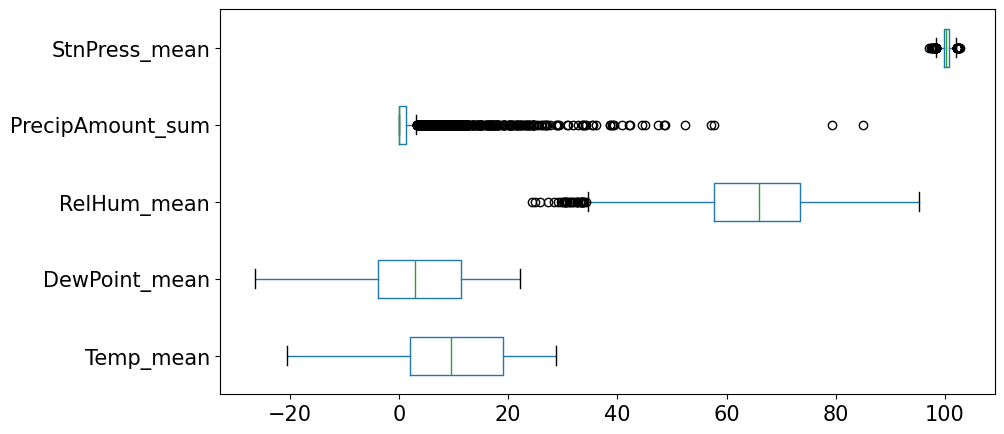

In [30]:
processed_df[['Temp_mean', 'DewPoint_mean', \
              'RelHum_mean', 'PrecipAmount_sum', 'StnPress_mean']] \
            .boxplot(grid=False, vert=False, fontsize=15, figsize=(10, 5))
plt.show()

In [31]:
processed_df[['Temp_mean', 'DewPoint_mean', \
              'RelHum_mean', 'PrecipAmount_sum', 'StnPress_mean']] \
            .describe()

,Temp_mean,DewPoint_mean,RelHum_mean,PrecipAmount_sum,StnPress_mean
count,3439.000000,3439.000000,3439.000000,3439.000000,3439.000000
mean,9.911634,3.213395,65.379223,2.209218,100.242320
std,10.047182,9.594449,12.105542,5.869038,0.724695
min,-20.504000,-26.329000,24.458000,0.000000,97.090000
25%,2.037500,-3.767000,57.792000,0.000000,99.778500
50%,9.588000,2.921000,66.000000,0.000000,100.240000
75%,19.112000,11.416500,73.479000,1.300000,100.714500
max,28.742000,22.221000,95.292000,84.900000,102.680000


Xác định ngoại lai

In [32]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [33]:
relhum_outliers = processed_df [ 
                          (processed_df['RelHum_mean'] > upper_bound['RelHum_mean']) 
                        | (processed_df['RelHum_mean'] < lower_bound['RelHum_mean'])
                        # | (processed_df['PrecipAmount_sum'] > upper_bound['PrecipAmount_sum']) 
                        # | (processed_df['PrecipAmount_sum'] < lower_bound['PrecipAmount_sum'])
                        # |  (processed_df['StnPress_mean'] > upper_bound['StnPress_mean']) 
                        # | (processed_df['StnPress_mean'] < lower_bound['StnPress_mean'])
                        ]

relhum_outliers.drop(columns=['Year', 'Month', 'Day']).describe()

,Temp_mean,Temp_max,Temp_min,DewPoint_mean,DewPoint_max,DewPoint_min,RelHum_mean,RelHum_max,RelHum_min,PrecipAmount_sum,StnPress_mean,StnPress_max,StnPress_min
count,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000
mean,12.548781,17.209375,8.150000,-4.534688,-0.37500,-8.253125,31.071625,45.250000,20.84375,0.046875,100.987844,101.194375,100.659375
std,6.054220,6.667851,5.778938,5.594354,5.73782,5.699065,2.607600,6.554978,3.97662,0.141386,0.515155,0.542800,0.512388
min,-4.362000,-2.600000,-7.700000,-18.233000,-13.80000,-23.500000,24.458000,33.000000,12.00000,0.000000,99.676000,99.850000,99.490000
25%,10.186750,14.600000,6.475000,-7.082000,-3.35000,-11.525000,30.198000,40.000000,18.00000,0.000000,100.696750,100.875000,100.307500
50%,13.473000,18.150000,8.900000,-3.812500,-0.45000,-7.150000,31.437500,45.500000,22.00000,0.000000,101.130500,101.280000,100.675000
75%,15.554000,20.925000,10.850000,-1.531250,3.60000,-5.650000,33.198000,50.000000,23.25000,0.000000,101.271000,101.572500,100.977500
max,25.938000,32.700000,19.200000,8.008000,10.00000,6.000000,34.250000,62.000000,27.00000,0.600000,101.827000,102.100000,101.530000


In [34]:
precip_outliers = processed_df [ 
                                  (processed_df['PrecipAmount_sum'] > upper_bound['PrecipAmount_sum'])
                                | (processed_df['PrecipAmount_sum'] < lower_bound['PrecipAmount_sum'])]

precip_outliers.drop(columns=['Year', 'Month', 'Day']).describe()

,Temp_mean,Temp_max,Temp_min,DewPoint_mean,DewPoint_max,DewPoint_min,RelHum_mean,RelHum_max,RelHum_min,PrecipAmount_sum,StnPress_mean,StnPress_max,StnPress_min
count,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,10.070052,13.458031,7.317444,5.945518,9.397755,1.989637,77.244522,91.834197,57.013817,11.494991,99.753627,100.269154,99.268756
std,9.024750,9.755989,8.903465,8.472819,8.114499,9.161609,8.227641,3.309335,14.160834,9.935910,0.688823,0.669045,0.762599
min,-15.329000,-13.800000,-18.200000,-19.033000,-16.200000,-27.000000,49.917000,78.000000,18.000000,3.300000,97.090000,98.160000,96.440000
25%,3.104500,5.100000,0.800000,-0.566500,3.000000,-4.750000,72.021000,90.000000,47.000000,5.100000,99.364500,99.830000,98.800000
50%,9.108000,13.000000,6.600000,5.308000,9.100000,1.200000,77.875000,92.000000,57.000000,8.000000,99.765000,100.230000,99.350000
75%,18.333000,22.100000,15.200000,13.508500,17.200000,9.500000,82.521000,94.000000,66.000000,14.300000,100.188000,100.655000,99.785000
max,27.350000,32.600000,23.100000,21.992000,25.100000,20.800000,95.000000,100.000000,92.000000,84.900000,101.513000,102.740000,101.220000


In [35]:
StnPress_outliers = processed_df [ 
                        # | (processed_df['PrecipAmount_sum'] > upper_bound['PrecipAmount_sum']) 
                        # | (processed_df['PrecipAmount_sum'] < lower_bound['PrecipAmount_sum'])
                          (processed_df['StnPress_mean'] > upper_bound['StnPress_mean']) 
                        | (processed_df['StnPress_mean'] < lower_bound['StnPress_mean'])
                        ]

relhum_outliers.drop(columns=['Year', 'Month', 'Day']).describe()

,Temp_mean,Temp_max,Temp_min,DewPoint_mean,DewPoint_max,DewPoint_min,RelHum_mean,RelHum_max,RelHum_min,PrecipAmount_sum,StnPress_mean,StnPress_max,StnPress_min
count,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000
mean,12.548781,17.209375,8.150000,-4.534688,-0.37500,-8.253125,31.071625,45.250000,20.84375,0.046875,100.987844,101.194375,100.659375
std,6.054220,6.667851,5.778938,5.594354,5.73782,5.699065,2.607600,6.554978,3.97662,0.141386,0.515155,0.542800,0.512388
min,-4.362000,-2.600000,-7.700000,-18.233000,-13.80000,-23.500000,24.458000,33.000000,12.00000,0.000000,99.676000,99.850000,99.490000
25%,10.186750,14.600000,6.475000,-7.082000,-3.35000,-11.525000,30.198000,40.000000,18.00000,0.000000,100.696750,100.875000,100.307500
50%,13.473000,18.150000,8.900000,-3.812500,-0.45000,-7.150000,31.437500,45.500000,22.00000,0.000000,101.130500,101.280000,100.675000
75%,15.554000,20.925000,10.850000,-1.531250,3.60000,-5.650000,33.198000,50.000000,23.25000,0.000000,101.271000,101.572500,100.977500
max,25.938000,32.700000,19.200000,8.008000,10.00000,6.000000,34.250000,62.000000,27.00000,0.600000,101.827000,102.100000,101.530000


In [37]:


# Giả sử df là DataFrame của bạn và column là cột bạn muốn kiểm tra
iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(processed_df[['Temp_mean', \
    'DewPoint_mean', 'RelHum_mean', 'PrecipAmount_sum', 'StnPress_mean']])
processed_df['outlier'] = outliers

# Loại bỏ các giá trị ngoại lai
df_cleaned = processed_df[processed_df['outlier'] == 1]

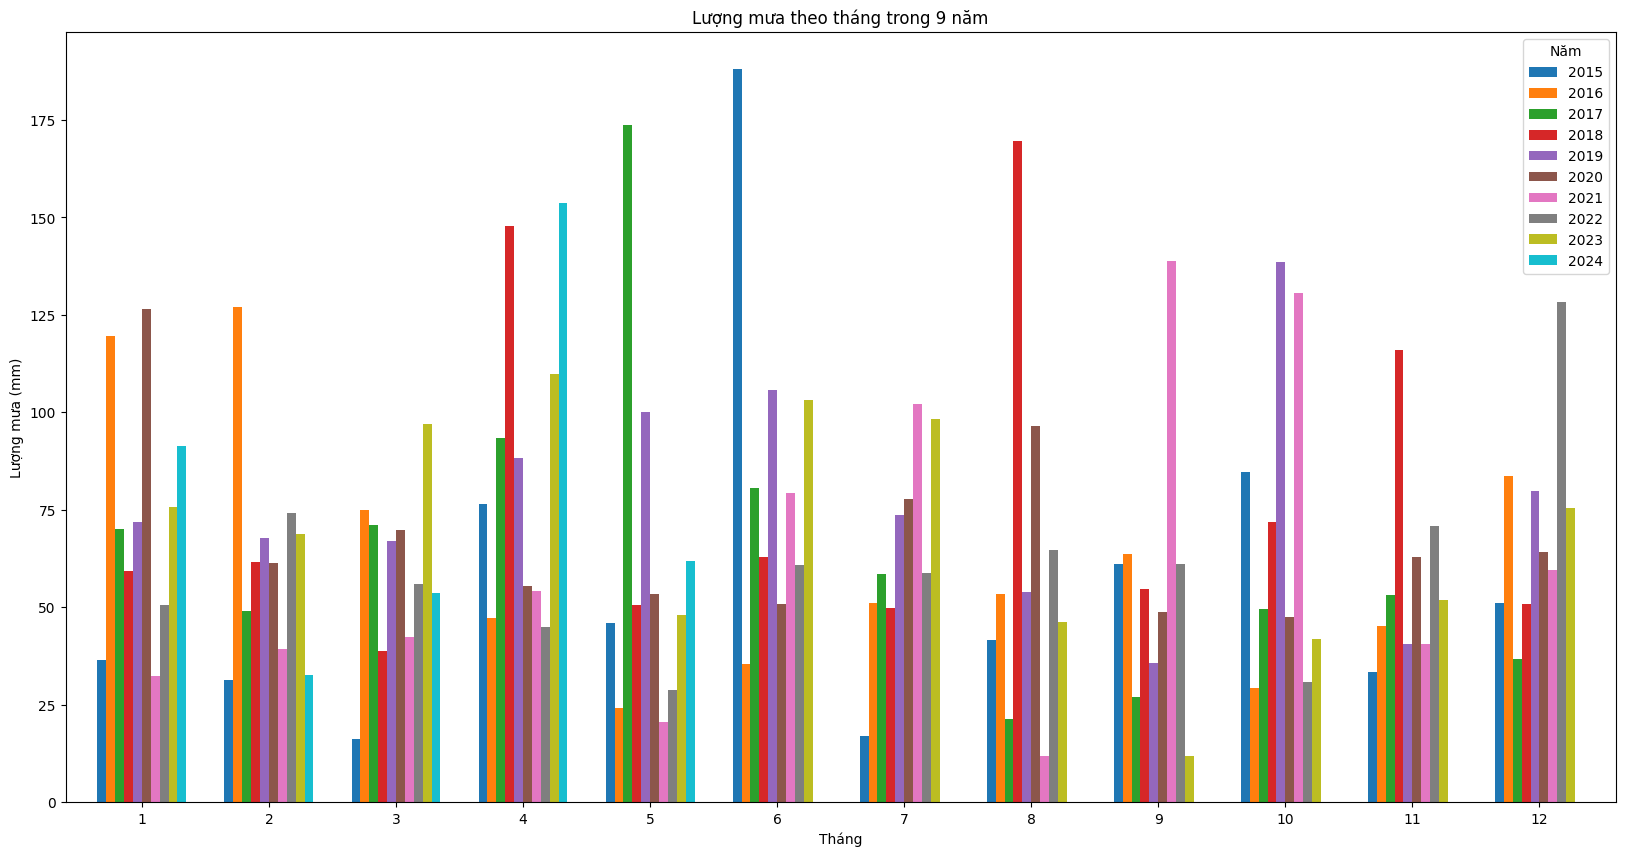

In [38]:
precipGroupedByMonth = processed_df.groupby(['Year', 'Month'])['PrecipAmount_sum'].sum().unstack(level=0)

# Vẽ biểu đồ cột
precipGroupedByMonth.plot(kind='bar', figsize=(20, 10), width=0.7)
plt.title('Lượng mưa theo tháng trong 9 năm')
plt.xlabel('Tháng')
plt.ylabel('Lượng mưa (mm)')
plt.legend(title='Năm')
plt.xticks(rotation=0)
plt.show()

In [39]:
new_df = processed_df.drop(columns=['outlier'])
new_df['Temp_range'] = new_df['Temp_max'] - new_df['Temp_min']
new_df = new_df.drop(columns=['Temp_max', 'Temp_min'])
new_df['DewPoint_range'] = new_df['DewPoint_max'] - new_df['DewPoint_min']
new_df = new_df.drop(columns=['DewPoint_max', 'DewPoint_min'])
new_df['RelHum_range'] = new_df['RelHum_max'] - new_df['RelHum_min']
new_df = new_df.drop(columns=['RelHum_max', 'RelHum_min'])
new_df['StnPress_range'] = new_df['StnPress_max'] - new_df['StnPress_min']
new_df = new_df.drop(columns=['StnPress_max', 'StnPress_min'])

new_df.drop(columns=['Year', 'Month', 'Day']).corr()

,Temp_mean,DewPoint_mean,RelHum_mean,PrecipAmount_sum,StnPress_mean,Temp_range,DewPoint_range,RelHum_range,StnPress_range
Temp_mean,1.000000,0.952349,-0.107728,0.021149,-0.199534,0.312990,-0.149912,0.279574,-0.404566
DewPoint_mean,0.952349,1.000000,0.196505,0.128789,-0.287688,0.185188,-0.223881,0.206460,-0.348928
RelHum_mean,-0.107728,0.196505,1.000000,0.394714,-0.318417,-0.397070,-0.232920,-0.215627,0.173385
PrecipAmount_sum,0.021149,0.128789,0.394714,1.000000,-0.289860,-0.111819,0.049728,0.014690,0.231887
StnPress_mean,-0.199534,-0.287688,-0.318417,-0.289860,1.000000,0.037438,-0.056066,-0.121922,-0.124825
Temp_range,0.312990,0.185188,-0.397070,-0.111819,0.037438,1.000000,0.344769,0.396288,-0.013748
DewPoint_range,-0.149912,-0.223881,-0.232920,0.049728,-0.056066,0.344769,1.000000,0.457316,0.392839
RelHum_range,0.279574,0.206460,-0.215627,0.014690,-0.121922,0.396288,0.457316,1.000000,0.027344
StnPress_range,-0.404566,-0.348928,0.173385,0.231887,-0.124825,-0.013748,0.392839,0.027344,1.000000


In [ ]:
processed_df = pd.read_csv("preProcessedDataWithHmdx.csv", low_memory=False)

processed_df['Temp_range'] = processed_df['Temp_max'] - processed_df['Temp_min']
processed_df = processed_df.drop(columns=['Temp_max', 'Temp_min'])
processed_df['DewPoint_range'] = processed_df['DewPoint_max'] - processed_df['DewPoint_min']
processed_df = processed_df.drop(columns=['DewPoint_max', 'DewPoint_min'])
processed_df['RelHum_range'] = processed_df['RelHum_max'] - processed_df['RelHum_min']
processed_df = processed_df.drop(columns=['RelHum_max', 'RelHum_min'])
processed_df['StnPress_range'] = processed_df['StnPress_max'] - processed_df['StnPress_min']
processed_df = processed_df.drop(columns=['StnPress_max', 'StnPress_min'])

processed_df.to_csv("preProcessedDataWithHmdx.csv", index=False)

In [46]:


class DecisionTreeModel:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.accuracy = None
        self.core = None
        self.dataSet = None
        self.higCorCol = None
        self.preKey = None
        self.y_pred = None

        pass
    
    def AddDataSet(self, seed):
        #Check seed in valid form
        if isinstance(seed, pd.DataFrame):
            print("Insert successfully")
            self.dataSet = seed
        else:
            print("Can't insert. Check input frame again.")
    
    def TrainTestSplit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        key = self.preKey
        df = self.HighCorrelationRemove()
        df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
        self.x_test = df_test.drop(key, axis=1)
        self.y_test = df_test[key]
        #over sampling using smote
        smote = SMOTE(random_state=42)
        x_train = df_train.drop(key, axis=1)
        y_train = df_train[key]
        self.x_train, self.y_train = smote.fit_resample(x_train, y_train)
        

    def SetPredictionKey(self, key):
        if self.dataSet is None:
            print("Insert dataset (pandas data frame) first")
            return
        if key in self.dataSet.columns:
            self.preKey = key
            self.HighCorrelationDetect()
            self.TrainTestSplit()
            print("Insert successfully")
        else:
            print("Can't insert. Check input key again.")
    
    def Fit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        x_train, y_train = self.x_train, self.y_train
        core = DecisionTreeClassifier()
        core.fit(x_train, y_train)
        self.core = core
        print("Fit finish successfully!")

    def Prediction(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and fit first.")
            return
        x_test = self.x_test
        y_pred = self.core.predict(x_test)
        self.y_pred = y_pred
        print("Accuracy for this prediction: ", self.Evaluation())

        return y_pred

    def Evaluation(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        self.accuracy = accuracy_score(y_test, y_pred)
        return self.accuracy

    def HighCorrelationDetect(self):
        exception = self.preKey
        threshold = 0.75
        df = copy.deepcopy(self.dataSet)
        columns = df.columns
        for label in columns:
            if df[label].dtype == 'object':
                df = df.drop(label, axis=1)
        #corr matrix
        corr_matrix = df.corr().abs()
        #result set
        result = list()
        #columns of corr matrix
        columns = corr_matrix.columns
        col_num = len(columns)
        #loop through the columns
        i = 0
        while i < col_num:
            for j in range(0, i):
                if exception != columns[i] \
                and corr_matrix.iloc[i, j] > threshold \
                and columns[i] not in result:
                    result.append(columns[i])
            i += 1
        self.higCorCol = result

    def HighCorrelationRemove(self):
        result = copy.deepcopy(self.dataSet)
        higCorCol = self.higCorCol
        for i in higCorCol:
            result.drop(i, axis=1)
        return result

    def PredictionDetails(self):
        y_test = self.y_test
        y_pred = self.y_pred
        print("Mark as possitive label: ", y_test[0])
        # Precision
        precision = precision_score(y_test, y_pred, pos_label=y_test[0])
        print("Precision:", precision)

        # Recall
        recall = recall_score(y_test, y_pred, pos_label=y_test[0])
        print("Recall:", recall)

        # F1-score
        f1 = f1_score(y_test, y_pred, pos_label=y_test[0])
        print("F1-score:",f1)

    def PredictionConfusionMatrix(self):
        y_test = self.y_test
        y_pred = self.y_pred
        # Create the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Visualize the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
    def report(self):
        if self.x_test is None or self.y_test is None or self.y_pred is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        print(classification_report(y_test, y_pred))

In [47]:
df = pd.read_csv('./preProcessedDataWithHmdx.csv');
print(df);
dtm = DecisionTreeModel();
dtm.AddDataSet(df);
dtm.SetPredictionKey('HMDX_label');
dtm.Fit();
print("Prediction Set: ", dtm.Prediction());

      Year  Month  Day  Temp_mean  DewPoint_mean  RelHum_mean  \
0     2015      1    1     -5.092        -12.758       55.125   
1     2015      1    2     -1.729         -8.804       59.250   
2     2015      1    3     -1.417         -5.121       76.750   
3     2015      1    4      2.854          1.988       94.333   
4     2015      1    5     -7.196        -12.212       67.833   
...    ...    ...  ...        ...            ...          ...   
3434  2024      5   27     18.650         14.708       79.083   
3435  2024      5   28     17.042         13.283       79.042   
3436  2024      5   29     16.838          9.192       65.250   
3437  2024      5   30     14.888          2.279       43.875   
3438  2024      5   31     16.258          3.900       45.083   

      PrecipAmount_sum  StnPress_mean  HMDX HMDX_label  Temp_range  \
0                  0.0         99.931   0.0       Safe         4.4   
1                  0.0        100.519   0.0       Safe         2.4   
2        

In [ ]:
dtm.report()

In [49]:
class NaiveBayes:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.accuracy = None
        self.core = None
        self.dataSet = None
        self.higCorCol = None
        self.preKey = None
        self.y_pred = None
    
    def AddDataSet(self, seed):
        #Check seed in valid form
        if isinstance(seed, pd.DataFrame):
            print("Insert successfully")
            self.dataSet = seed
        else:
            print("Can't insert. Check input frame again.")
    
    def TrainTestSplit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        key = self.preKey
        df = self.HighCorrelationRemove()
        df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
        self.x_test = df_test.drop(key, axis=1)
        self.y_test = df_test[key]
        #over sampling using smote
        smote = SMOTE(random_state=42)
        x_train = df_train.drop(key, axis=1)
        y_train = df_train[key]
        self.x_train, self.y_train = smote.fit_resample(x_train, y_train)
        

    def SetPredictionKey(self, key):
        if self.dataSet is None:
            print("Insert dataset (pandas data frame) first")
            return
        if key in self.dataSet.columns:
            self.preKey = key
            self.HighCorrelationDetect()
            self.TrainTestSplit()
            print("Insert successfully")
        else:
            print("Can't insert. Check input key again.")
    
    def Fit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        x_train, y_train = self.x_train, self.y_train
        core = GaussianNB()
        core.fit(x_train, y_train)
        self.core = core
        print("Fit finish successfully!")

    def Prediction(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and fit first.")
            return
        x_test = self.x_test
        y_pred = self.core.predict(x_test)
        self.y_pred = y_pred
        print("Accuracy for this prediction: ", self.Evaluation())

        return y_pred

    def Evaluation(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        self.accuracy = accuracy_score(y_test, y_pred)
        return self.accuracy

    def HighCorrelationDetect(self):
        exception = self.preKey
        threshold = 0.75
        df = copy.deepcopy(self.dataSet)
        columns = df.columns
        for label in columns:
            if df[label].dtype == 'object':
                df = df.drop(label, axis=1)
        #corr matrix
        corr_matrix = df.corr().abs()
        #result set
        result = list()
        #columns of corr matrix
        columns = corr_matrix.columns
        col_num = len(columns)
        #loop through the columns
        i = 0
        while i < col_num:
            for j in range(0, i):
                if exception != columns[i] \
                and corr_matrix.iloc[i, j] > threshold \
                and columns[i] not in result:
                    result.append(columns[i])
            i += 1
        self.higCorCol = result

    def HighCorrelationRemove(self):
        result = copy.deepcopy(self.dataSet)
        higCorCol = self.higCorCol
        for i in higCorCol:
            result.drop(i, axis=1)
        return result

    def PredictionDetails(self):
        y_test = self.y_test
        y_pred = self.y_pred
        print("Mark as possitive label: ", y_test[0])
        # Precision
        precision = precision_score(y_test, y_pred, pos_label=y_test[0])
        print("Precision:", precision)

        # Recall
        recall = recall_score(y_test, y_pred, pos_label=y_test[0])
        print("Recall:", recall)

        # F1-score
        f1 = f1_score(y_test, y_pred, pos_label=y_test[0])
        print("F1-score:",f1)

    def PredictionConfusionMatrix(self):
        y_test = self.y_test
        y_pred = self.y_pred
        # Create the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Visualize the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
    def report(self):
        if self.x_test is None or self.y_test is None or self.y_pred is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        print(classification_report(y_test, y_pred))

In [50]:
df = pd.read_csv('./preProcessedDataWithHmdx.csv')
nbm = NaiveBayes()
nbm.AddDataSet(df)
nbm.SetPredictionKey('HMDX_label')
nbm.Fit()
nbm.Prediction()

Insert successfully
Insert successfully
Fit finish successfully!
Accuracy for this prediction:  0.9563953488372093


array(['Unsafe', 'Safe', 'Unsafe', ..., 'Safe', 'Safe', 'Safe'],
      dtype='<U6')

In [51]:
nbm.report()

              precision    recall  f1-score   support

        Safe       1.00      0.96      0.98       979
      Unsafe       0.54      0.96      0.69        53

    accuracy                           0.96      1032
   macro avg       0.77      0.96      0.84      1032
weighted avg       0.97      0.96      0.96      1032



In [52]:
# Đọc tệp CSV đã tải lên
file_path = 'preProcessedDataWithHmdx.csv'
data = pd.read_csv(file_path)

# Hiển thị thông tin tổng quan về dữ liệu
data.info(), data.head()
data = data.drop(columns=['HMDX_label'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   DewPoint_mean     3439 non-null   float64
 5   RelHum_mean       3439 non-null   float64
 6   PrecipAmount_sum  3439 non-null   float64
 7   StnPress_mean     3439 non-null   float64
 8   HMDX              3439 non-null   float64
 9   HMDX_label        3439 non-null   object 
 10  Temp_range        3439 non-null   float64
 11  DewPoint_range    3439 non-null   float64
 12  RelHum_range      3439 non-null   float64
 13  StnPress_range    3439 non-null   float64
dtypes: float64(10), int64(3), object(1)
memory usage: 376.3+ KB


In [53]:
# Tính ma trận tương quan
correlation_matrix = data.corr()

# Xác định các cặp thuộc tính có tương quan lớn hơn 0.75
high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.75].stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]

# Lọc danh sách các cột cần loại bỏ
columns_to_drop = set()
for col1, col2, corr in high_corr_pairs.itertuples(index=False):
    # Chỉ giữ lại một cột trong mỗi cặp
    if col1 not in columns_to_drop:
        columns_to_drop.add(col2)

# Loại bỏ các cột có tương quan cao
filtered_data = data.drop(columns=list(columns_to_drop), axis=1)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   RelHum_mean       3439 non-null   float64
 5   PrecipAmount_sum  3439 non-null   float64
 6   StnPress_mean     3439 non-null   float64
 7   Temp_range        3439 non-null   float64
 8   DewPoint_range    3439 non-null   float64
 9   RelHum_range      3439 non-null   float64
 10  StnPress_range    3439 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 295.7 KB


In [54]:
# Kết hợp các cột Year, Month, Day thành một cột Date
filtered_data['Date'] = pd.to_datetime(filtered_data[['Year', 'Month', 'Day']])

# Đặt cột 'Date' làm chỉ số thời gian
filtered_data.set_index('Date', inplace=True)

# Xóa các cột không cần thiết
filtered_data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

train_data = filtered_data.iloc[:-30]['Temp_mean']
test_data = filtered_data.iloc[-30:]['Temp_mean']

In [55]:
result = adfuller(train_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.573411311709167
p-value: 0.006290171101920204


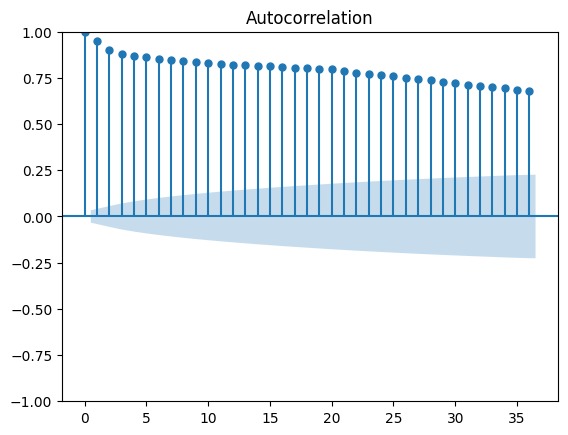

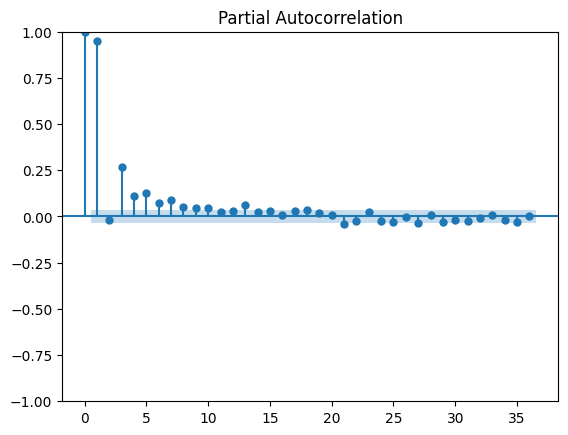

In [56]:
plot_acf(train_data)
plot_pacf(train_data)
plt.show()

In [57]:
# Tạo thư mục lưu đồ thị nếu chưa tồn tại
output_dir = "../arima_forecasts"
os.makedirs(output_dir, exist_ok=True)

def fit_arima(p, d, q):
    try:
        # Xây dựng và huấn luyện mô hình ARIMA
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()

        # Dự đoán
        forecast = model_fit.forecast(steps=30)

        # Vẽ đồ thị
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
        plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Temperature Mean')
        plt.title(f'ARIMA Forecast (p={p}, d={d}, q={q})')
        plt.legend()
        plt.grid()

        # Lưu đồ thị
        file_name = f"arima_p{p}_d{d}_q{q}.png"
        plt.savefig(os.path.join(output_dir, file_name))
        plt.close()
    except Exception as e:
        print(f"Failed for ARIMA(p={p}, d={d}, q={q}): {e}")

# Vòng lặp thử nghiệm các giá trị p, d, q
params = [(p, d, q) for p in range(8) for d in range(8) for q in range(8)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(lambda param: fit_arima(*param), params)


In [58]:


# Tạo thư mục lưu đồ thị nếu chưa tồn tại
output_dir = "../sarima_forecasts"
os.makedirs(output_dir, exist_ok=True)

P, D, Q = 1, 1, 1

def fit_sarima(p, d, q):
    try:
        # Xây dựng và huấn luyện mô hình SARIMA
        sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
        sarima_fit = sarima_model.fit(disp=False)

        # Dự đoán
        forecast_sarima = sarima_fit.forecast(steps=30)

        # Vẽ đồ thị
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
        plt.plot(test_data.index, forecast_sarima, label='Forecast', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Temperature Mean')
        plt.title(f'SARIMA Forecast (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
        plt.legend()
        plt.grid()

        # Lưu đồ thị
        file_name = f"sarima_p{p}_d{d}_q{q}_P{P}_D{D}_Q{Q}_S{S}.png"
        plt.savefig(os.path.join(output_dir, file_name))
        plt.close()
    except Exception as e:
        print(f"Failed for SARIMA(p={p}, d={d}, q={q}): {e}")

# Vòng lặp thử nghiệm các giá trị p, d, q
params = [(p, d, q) for p in range(8) for d in range(8) for q in range(8)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(lambda param: fit_sarima(*param), params)

In [59]:


output_dir = "../sarima_forecasts_2"
os.makedirs(output_dir, exist_ok=True)

S = 12

def fit_sarima(p, d, q, P, D, Q):
    try:
        # Xây dựng và huấn luyện mô hình SARIMA
        sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
        sarima_fit = sarima_model.fit(disp=False)

        # Dự đoán
        forecast_sarima = sarima_fit.forecast(steps=30)

        # Vẽ đồ thị
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
        plt.plot(test_data.index, forecast_sarima, label='Forecast', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Temperature Mean')
        plt.title(f'SARIMA Forecast (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
        plt.legend()
        plt.grid()

        # Lưu đồ thị
        file_name = f"sarima_p{p}_d{d}_q{q}_P{P}_D{D}_Q{Q}_S{S}.png"
        plt.savefig(os.path.join(output_dir, file_name))
        plt.close()
    except Exception as e:
        print(f"Failed for SARIMA(p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")

# Vòng lặp thử nghiệm các giá trị (p, d, q) và (P, D, Q)
params = [(p, d, q, P, D, Q) for p in range(3) for d in range(3) for q in range(3) for P in range(3) for D in range(3) for Q in range(3)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    executor.map(lambda param: fit_sarima(*param), params)

C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\phamg\AppData\Local\Pr

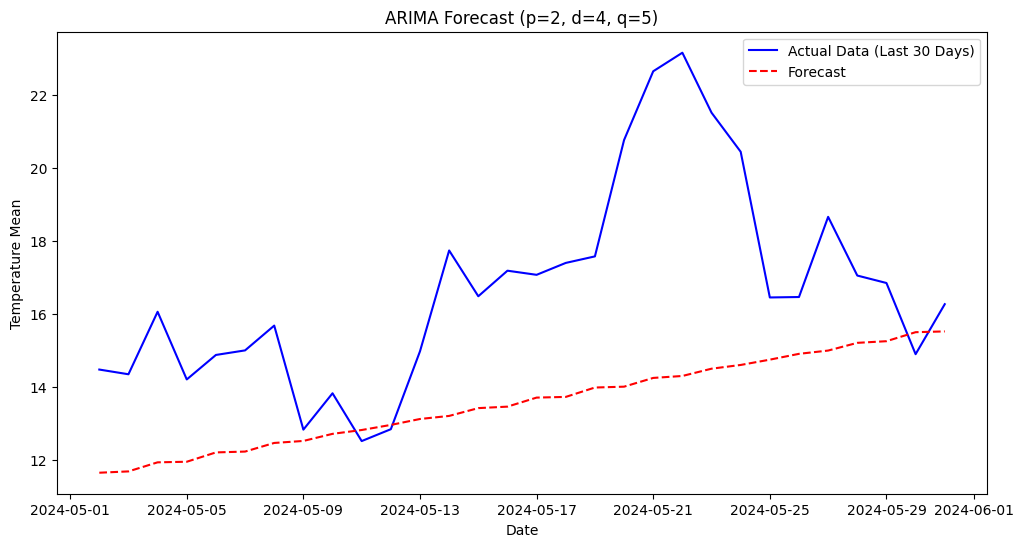

In [60]:
# Ensure that CELL INDEX: 4 is executed before this cell to define train_data and test_data
p, d, q = 2, 4, 5
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Dự đoán
forecast = model_fit.forecast(steps=30)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'ARIMA Forecast (p={p}, d={d}, q={q})')
plt.legend()
plt.show()

C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


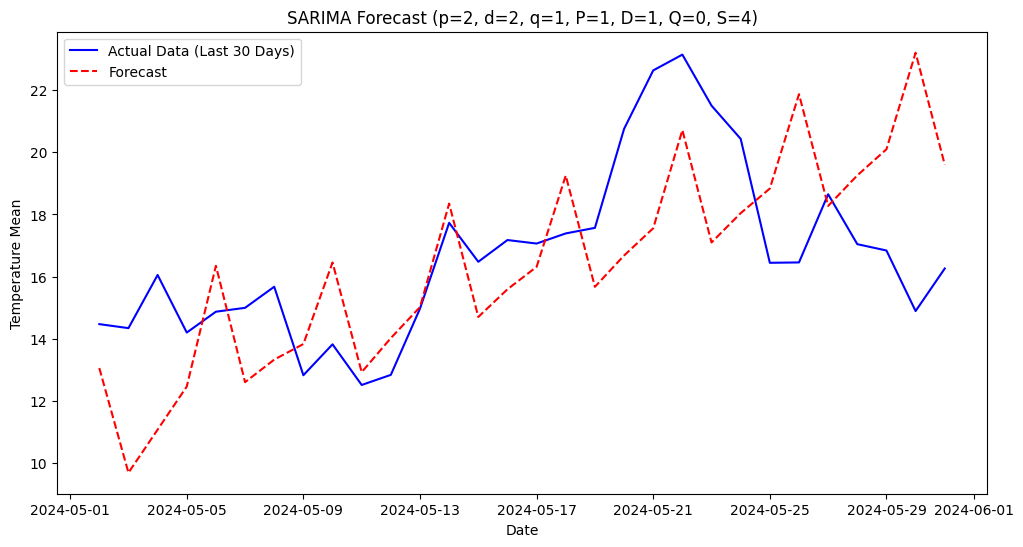

In [61]:
p, d, q, P, D, Q, S = 2, 2, 1, 1, 1, 0, 4

sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_fit = sarima_model.fit(disp=False)

# Dự đoán
forecast_sarima = sarima_fit.forecast(steps=30)
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_sarima, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'SARIMA Forecast (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
plt.legend()
plt.show()